<a href="https://www.kaggle.com/code/kodaifukuda0311/disaster-tweets-classification-with-rnn-and-cnn?scriptVersionId=205962577" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Natural Language Processing with Disaster Tweets

## 1.Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they are observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it is not always clear whether a person's words are actually announcing a disaster. In this competition, we are challenged to build a machine learning model that predicts which Tweets are about real disasters and which one's are not.

## 2.Data Overview

In [3]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Natual Language Processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [4]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Distribution of target
print((train_df.target == 1).sum())
print((train_df.target == 0).sum())

3271
4342


### Preprocessing : Removing URL, punctuations, and stopwords

In [6]:
# Preprocessing
import re
import string
# Remove URL from the text
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# Remove puctuations
def remove_punct(text):
    translator = str.maketrans('', '', string.punctuation) # Create a translation table to delete all punctuation
    return text.translate(translator) # Use this translation table to transform the text by removing punctuation characters

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
pattern = re.compile(r'https?://(\S+|www)\.\S+')
for t in train_df.text:
    matches = pattern.findall(t)
    for match in matches:
        print(t)
        print(match)
        print(pattern.sub(r'', t))
    if len(matches) > 0:
        break

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
t
@bbcmtd Wholesale Markets ablaze 


In [8]:
# Apply the functions
train_df['text'] = train_df.text.map(remove_URL) # map(lambda x : remove_URL(x))
train_df['text'] = train_df.text.map(remove_punct)

In [9]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def remove_stopwords(text):
  filtered_words = [word for word in text.split() if word not in stopwords.words('english')]
  return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# 5 exapmles of stopwords
import random
random.sample(stop, 5)

/tmp/ipykernel_30/2665483320.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(stop, 5)


['very', "you'd", 'now', 'into', 'then']

In [12]:
# The length of text
text_length = train_df['text'].str.len()
text_length.describe()

count    7613.000000
mean       83.591226
std        31.460470
min         6.000000
25%        60.000000
50%        85.000000
75%       109.000000
max       145.000000
Name: text, dtype: float64

In [13]:
# Apply the function
train_df['text'] = train_df['text'].map(remove_stopwords)
train_df.text

0        Our Deeds Reason earthquake May ALLAH Forgive us
1                   Forest fire near La Ronge Sask Canada
2       All residents asked shelter place notified off...
3       13000 people receive wildfires evacuation orde...
4       Just got sent photo Ruby Alaska smoke wildfire...
                              ...                        
7608    Two giant cranes holding bridge collapse nearb...
7609    ariaahrary TheTawniest The control wild fires ...
7610                    M194 0104 UTC5km S Volcano Hawaii
7611    Police investigating ebike collided car Little...
7612    The Latest More Homes Razed Northern Californi...
Name: text, Length: 7613, dtype: object

### Count the number of unique words

In [14]:
# Count unique words
from collections import Counter

def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

In [15]:
# The number of unique words
counter = counter_word(train_df.text)
num_unique_words = len(counter)
num_unique_words

22093

In [16]:
counter.most_common(5)

[('I', 1225), ('The', 581), ('like', 321), ('A', 302), ('amp', 298)]

## 3.Tokenize the text data

In [17]:
# Split the data
from sklearn.model_selection import train_test_split
X = train_df.text
y = train_df.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [18]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [19]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# Vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words = num_unique_words)
tokenizer.fit_on_texts(X_train)

In [20]:
word_index = tokenizer.word_index

# 5 samples of word_index
random_keys = random.sample(list(word_index.keys()), 5)
for key in random_keys:
  print(f"key: {key}, value: {word_index[key]}")

key: mattkroschel, value: 12604
key: threats, value: 2839
key: chronicillness, value: 9718
key: contained, value: 5688
key: bluewestlo, value: 10291


In [21]:
# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

# An example
print(X_train[1:3])
print(train_sequences[1:3])

['This first year Forest Service spent half annual budget fighting fires climatechange'
 'lightseraphs pissed could pikachu electrocute']
[[28, 36, 120, 116, 310, 1747, 419, 1748, 1553, 1180, 44, 3810], [5760, 3811, 84, 5761, 533]]


### Pad the sequences to have the same length

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [23]:
print(X_train[10])
print(train_sequences[10])
print(train_padded[10])

WeaponXmusic hey guys thanks rock world follow
[5771, 627, 536, 447, 1182, 49, 842]
[5771  627  536  447 1182   49  842    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [24]:
# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [25]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[5771, 627, 536, 447, 1182, 49, 842]
weaponxmusic hey guys thanks rock world follow


## 4.Build the RNN model; LSTM

In [26]:
# RNN model
model = keras.models.Sequential()
model.add(layers.Embedding(input_dim = num_unique_words,
                           output_dim = 32,
                           input_length = max_length))

# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

model.add(layers.LSTM(256, return_sequences=True, dropout=0.1))

model.add(LSTM(256, return_sequences=True, dropout=0.1))

model.add(LSTM(256))

model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation="sigmoid"))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_padded, y_train, epochs=10, batch_size=64, validation_data=(val_padded, y_val), callbacks=[early_stopping])

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 0.5790 - loss: 0.6825 - val_accuracy: 0.6566 - val_loss: 0.6655
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.7017 - loss: 0.5827 - val_accuracy: 0.7584 - val_loss: 0.5028
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.8233 - loss: 0.4030 - val_accuracy: 0.7800 - val_loss: 0.4722
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8713 - loss: 0.3209 - val_accuracy: 0.7932 - val_loss: 0.5239
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.9099 - loss: 0.2332 - val_accuracy: 0.7873 - val_loss: 0.5296
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.9297 - loss: 0.1848 - val_accuracy: 0.7833 - val_loss: 0.5899


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7755 - loss: 0.4780
Loss: 0.47220849990844727
Accuracy: 0.780039370059967


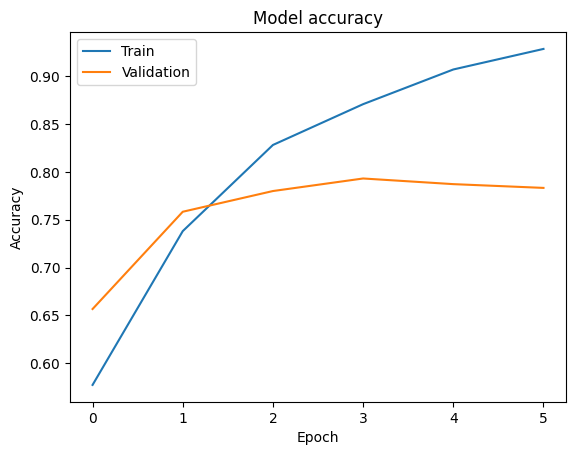

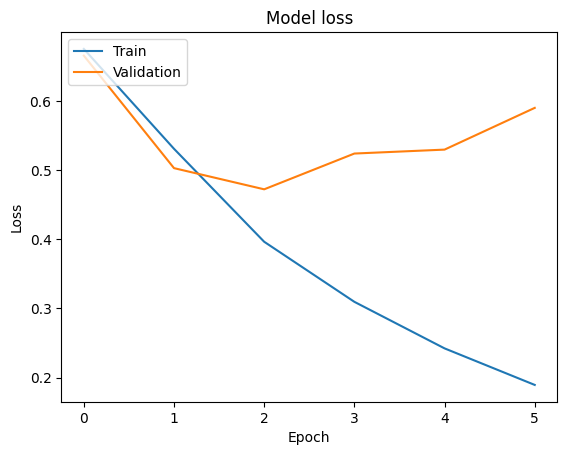

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(val_padded, y_val)
print('Loss:', loss)
print('Accuracy:', accuracy)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 5.Bidirectional + Stacked LSTM

A Bidirectional LSTM is a modification of the standard LSTM that processes the input sequence in both directions (forward and backward). The model gets both past (previous tokens) and future (subsequent tokens) context for each token in the sequence. In sentence classification, the meaning of a word can often depend on the surrounding words both before and after it.

A Stacked LSTM refers to the configuration where multiple LSTM layers are stacked on top of each other, creating a deep LSTM network. This allows the model to learn hierarchical representations of the input sequence, where each layer can capture more abstract or complex features of the sequence at different levels.

Let's create a model that combines the BiLSTM and Stacked LSTM methods and check the accuracy.

In [30]:
# Bidirectional + Stacked LSTM
from tensorflow.keras.layers import Bidirectional

model_bi = keras.models.Sequential()
model_bi.add(Embedding(input_dim = num_unique_words,
                           output_dim = 32,
                           input_length = max_length))

model_bi.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.1)))

model_bi.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.1)))

model_bi.add(LSTM(256))

model_bi.add(Dropout(0.3))

model_bi.add(Dense(32, activation='relu'))

model_bi.add(Dense(1, activation="sigmoid"))

model_bi.summary()

# Compile
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
model_bi.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_bi = model_bi.fit(train_padded, y_train, epochs=10, batch_size=64, validation_data=(val_padded, y_val), callbacks=[early_stopping])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 51s 425ms/step - accuracy: 0.5651 - loss: 0.6839 - val_accuracy: 0.6349 - val_loss: 0.6888
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 410ms/step - accuracy: 0.7109 - loss: 0.5639 - val_accuracy: 0.7603 - val_loss: 0.5058
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.8376 - loss: 0.3754 - val_accuracy: 0.7800 - val_loss: 0.5238
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 411ms/step - accuracy: 0.8894 - loss: 0.2822 - val_accuracy: 0.7866 - val_loss: 0.5170
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.9159 - loss: 0.2292 - val_accuracy: 0.7630 - val_loss: 0.5926


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.7620 - loss: 0.5107
Loss: 0.5058469772338867
Accuracy: 0.7603414058685303


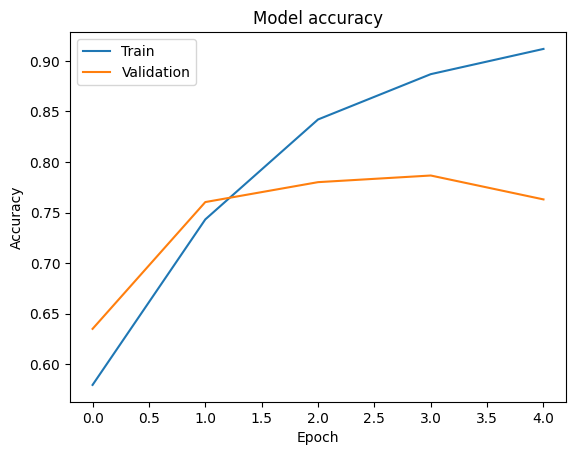

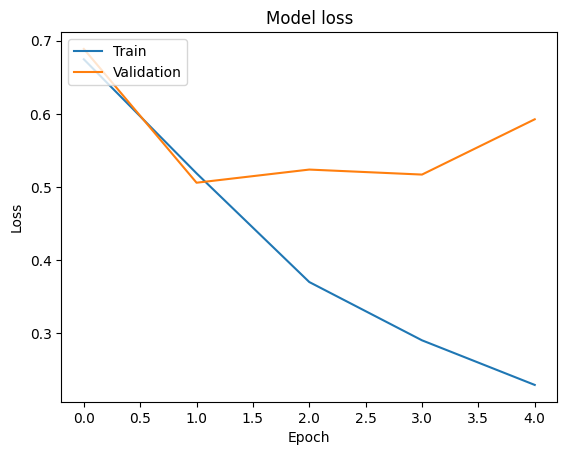

In [31]:
# Evaluate the model
loss_bi, accuracy_bi = model_bi.evaluate(val_padded, y_val)
print('Loss:', loss_bi)
print('Accuracy:', accuracy_bi)

# Plot the training and validation accuracy
plt.plot(history_bi.history['accuracy'])
plt.plot(history_bi.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_bi.history['loss'])
plt.plot(history_bi.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## 6.Convolutional Neural Network
CNN can be applied to Natural Language Processing tasks, and in some cases, they are an effective alternative to RNN. While RNN is often used for tasks that require sequential information (e.g., language modeling, translation), CNN can also be adapted to capture important features in sequences like text.

While RNN is sequential, CNN does not inherently have this "memory" across steps. However, CNN can process input text more efficiently and capture local patterns, making them well-suited for tasks like text classification.

In fact, as shown below, the CNN achieved a slightly higher score than when the RNN was applied.

In [70]:
# CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=num_unique_words, output_dim=128, input_length=max_length))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())
model_cnn.add(Dense(10, activation='relu'))
model_cnn.add(Dropout(0.35))
model_cnn.add(Dense(1, activation='sigmoid'))

# Compile
opt = Adam(learning_rate=0.0001)
model_cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_cnn = model_cnn.fit(train_padded, y_train, epochs=20, batch_size=32, validation_data=(val_padded, y_val), callbacks=[early_stopping])

# Evaluate the model
loss_cnn, accuracy_cnn = model_cnn.evaluate(val_padded, y_val)
print('Loss:', loss_cnn)
print('Accuracy:', accuracy_cnn)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5544 - loss: 0.6890 - val_accuracy: 0.5817 - val_loss: 0.6758
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5720 - loss: 0.6737 - val_accuracy: 0.5955 - val_loss: 0.6640
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6042 - loss: 0.6491 - val_accuracy: 0.6645 - val_loss: 0.6272
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7352 - loss: 0.5708 - val_accuracy: 0.7735 - val_loss: 0.5419
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8642 - loss: 0.4358 - val_accuracy: 0.7925 - val_loss: 0.4920
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9069 - loss: 0.3171 - val_accuracy: 0.8011 - val_loss: 0.4747
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9304 - loss: 0.2402 - val_accuracy: 0.7991 - val_loss: 0.5095
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9485 - loss: 0.1915 - val_accu

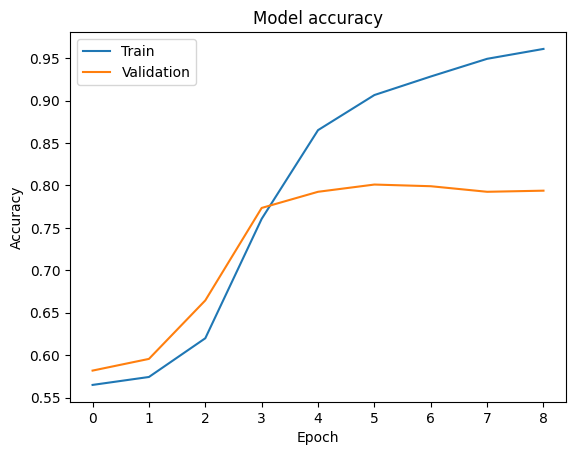

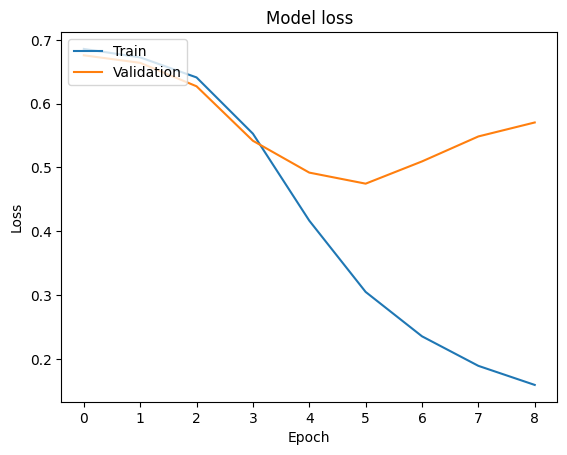

In [72]:
# Plot the training and validation accuracy
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 7.Comparison with XGBoost
We also evaluated the classification accuracy using an algorithm that uses TF-IDF vectorization and XGBoost.

Without tuning hyperparameters, there was not much difference from the Deep Learning method.

In [75]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = xgb_model.predict(X_val_tfidf)

# Evaluate accuracy
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       886
           1       0.83      0.59      0.69       637

    accuracy                           0.78      1523
   macro avg       0.80      0.75      0.76      1523
weighted avg       0.79      0.78      0.77      1523



In [76]:
# TF-IDF vectorization for test_df
test_df['text'] = test_df.text.map(remove_URL)
test_df['text'] = test_df.text.map(remove_punct)
test_df['text'] = test_df['text'].map(remove_stopwords)

X_test_tfidf = vectorizer.transform(test_df.text)

# Make predictions on test_df
y_test_pred = xgb_model.predict(X_test_tfidf)

# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_df.id, 'target': y_test_pred})

# Save submission to CSV
submission_df.to_csv('submission_xgb.csv', index=False)

## 8.Conclusion and Submission
I compared three models: LSTM, BiLSTM, CNN, and XGBoost. As a result, the CNN model reached the best score among these.

I tried various hyperparameters for RNN and CNN, but it was difficult to get a final score of 0.8 or higher. Similar scores were obtained with XGBoost. Although the score was not bad, there seemed to be room for improvement.

Looking at the models of other participants in this Kaggle competition, the models with high accuracy applied pre-trained models such as BERT  (Bidirectional Encoder Representations from Transformers).

In [73]:
# Preprocess the test data
test_df['text'] = test_df.text.map(remove_URL)
test_df['text'] = test_df.text.map(remove_punct)
test_df['text'] = test_df['text'].map(remove_stopwords)

# Convert test data to sequences using the same tokenizer
test_sequences = tokenizer.texts_to_sequences(test_df.text)

# Pad the sequences to have the same length as the training data
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

# Predict labels for the test data
predictions = model_cnn.predict(test_padded)

# Convert probabilities to class labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Add the predicted labels to the test dataframe
test_df['predicted_label'] = predicted_labels

print(test_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
   id keyword location                                               text  \
0   0     NaN      NaN                   Just happened terrible car crash   
1   2     NaN      NaN  Heard earthquake different cities stay safe ev...   
2   3     NaN      NaN  forest fire spot pond geese fleeing across str...   
3   9     NaN      NaN              Apocalypse lighting Spokane wildfires   
4  11     NaN      NaN             Typhoon Soudelor kills 28 China Taiwan   

   predicted_label  
0                1  
1                0  
2                1  
3                1  
4                1  


In [74]:
submission = pd.DataFrame({
    'id':test_df.id,
    'target':test_df.predicted_label
})

submission.to_csv('submission_cnn_final.csv', index=False)